## 00. Imports

In [76]:
import cv2
import numpy as np
import rawpy
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 01. Load images

In [34]:
def load_image(image_path):
    ext = os.path.splitext(image_path)[-1].lower()
    if ext in ['.jpg', '.jpeg', '.png']:
        image = cv2.imread(image_path)
    elif ext in ['.dng', '.nef', '.cr2']:  # RAW formats
        with rawpy.imread(image_path) as raw:
            image = raw.postprocess()
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        raise ValueError("Unsupported file format")
    return image

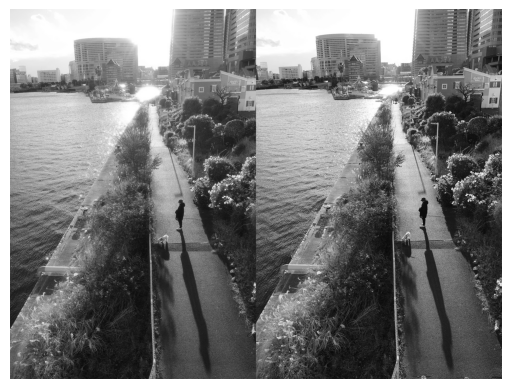

In [50]:
DIR = "ricoh-dataset/"
image_path = ".jpg"  # Change this to your image path
image_diff = load_image(f"{DIR}ricoh_images_diff.jpg")

image_org = load_image(f"{DIR}ricoh_images_org.jpg")

# Display the image using matplotlib
plt.imshow(np.hstack([image_diff, image_org]))
plt.axis('off')  # Hide the axis
plt.show()

## 02. Compute local intensity statistics - variance

In [57]:
def compute_local_variance(image, kernel_size=5):
    mean = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    mean_sq = cv2.GaussianBlur(image**2, (kernel_size, kernel_size), 0)
    variance = mean_sq - mean**2
    return variance

def compute_local_standard_deviation(image, kernel_size=5):
    return np.sqrt(compute_local_variance(image, kernel_size))

In [81]:
def extract_bright_differences(image1, image2, variance1, variance2, std1, std2, brightness_threshold=200):
    """
    Extracts the differences between two images and their respective variances and standard deviations in bright regions.
    
    Parameters:
    - image1, image2: Input images to compare.
    - variance1, variance2: Local variance maps for the respective images.
    - std1, std2: Local standard deviation maps for the respective images.
    - brightness_threshold: The pixel intensity threshold to define bright regions.

    Returns:
    - bright_diff_image: Intensity difference in bright regions.
    - bright_diff_variance: Variance difference in bright regions.
    - bright_diff_std: Standard deviation difference in bright regions.
    """
    # Create binary masks for bright regions in both images
    bright_mask1 = image1 > brightness_threshold
    bright_mask2 = image2 > brightness_threshold
    
    # Compute the absolute differences between the images and their variances
    diff_image = np.abs(image1.astype(np.int16) - image2.astype(np.int16))
    diff_variance = np.abs(variance1 - variance2)
    
    # Apply the bright region mask to get differences only in bright areas
    bright_diff_image = np.where(bright_mask1 & bright_mask2, diff_image, 0)
    bright_diff_variance = np.where(bright_mask1 & bright_mask2, diff_variance, 0)
    
    # Compute the absolute difference between standard deviations
    diff_std = np.abs(std1 - std2)
    bright_diff_std = np.where(bright_mask1 & bright_mask2, diff_std, 0)
    
    return bright_diff_image.astype(np.uint8), bright_diff_variance.astype(np.uint8), bright_diff_std.astype(np.uint8)


def plot_statistics(image1, variance1, std1, image2, variance2, std2, diff_image, diff_variance, diff_std, name1="diff", name2="org"):
    """
    Plots various statistical comparisons between two images and their respective differences in bright regions.
    
    Parameters:
    - image1, image2: Input images to compare.
    - variance1, variance2: Local variance maps for the respective images.
    - std1, std2: Standard deviations for the images.
    - diff_image: Difference in image intensities.
    - diff_variance: Difference in variances.
    - diff_std: Difference in standard deviations.
    - name1, name2: Labels for the images in the plot legend.
    """
    plt.figure(figsize=(15, 12))  # Adjusting the figure size to fit all subplots

    # Plot pixel intensity distribution
    plt.subplot(2, 3, 1)
    plt.hist(image1.ravel(), bins=256, range=(0, 255), alpha=0.5, color='blue', label=name1)
    plt.hist(image2.ravel(), bins=256, range=(0, 255), alpha=0.5, color='green', label=name2)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.legend()

    # Plot local variance distribution
    plt.subplot(2, 3, 2)
    plt.hist(variance1.ravel(), bins=256, alpha=0.5, color='red', label=name1)
    plt.hist(variance2.ravel(), bins=256, alpha=0.5, color='purple', label=name2)
    plt.title("Local Variance Distribution")
    plt.xlabel("Variance")
    plt.ylabel("Frequency")
    plt.legend()

    # Plot standard deviation in bright regions
    plt.subplot(2, 3, 3)
    plt.hist(std1.ravel(), bins=256, alpha=0.75, color='black', label=name1)
    plt.hist(std2.ravel(), bins=256, alpha=0.75, color='orange', label=name2)
    plt.title("Standard Deviation Distribution")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.legend()

    # Plot image difference in bright regions
    plt.subplot(2, 3, 4)
    plt.hist(diff_image.ravel(), bins=256, alpha=0.75, color='black', label='Image Difference', range=(1, 255))
    plt.title("Difference in Bright Regions (Excluding Zero)")
    plt.xlabel("Intensity Difference")
    plt.ylabel("Frequency")
    plt.legend()

    # Plot variance difference in bright regions
    plt.subplot(2, 3, 5)
    plt.hist(diff_variance.ravel(), bins=256, alpha=0.75, color='orange', label='Variance Difference', range=(1, 255))
    plt.title("Variance Difference in Bright Regions (Excluding Zero)")
    plt.xlabel("Variance Difference")
    plt.ylabel("Frequency")
    plt.legend()

    # Plot standard deviation difference in bright regions
    plt.subplot(2, 3, 6)
    plt.hist(diff_std.ravel(), bins=256, alpha=0.75, color='purple', label='Standard Deviation Difference', range=(1, 255))
    plt.title("Standard Deviation Difference in Bright Regions (Excluding Zero)")
    plt.xlabel("Standard Deviation Difference")
    plt.ylabel("Frequency")
    plt.legend()

    # Display all the plots
    plt.tight_layout()
    plt.show()


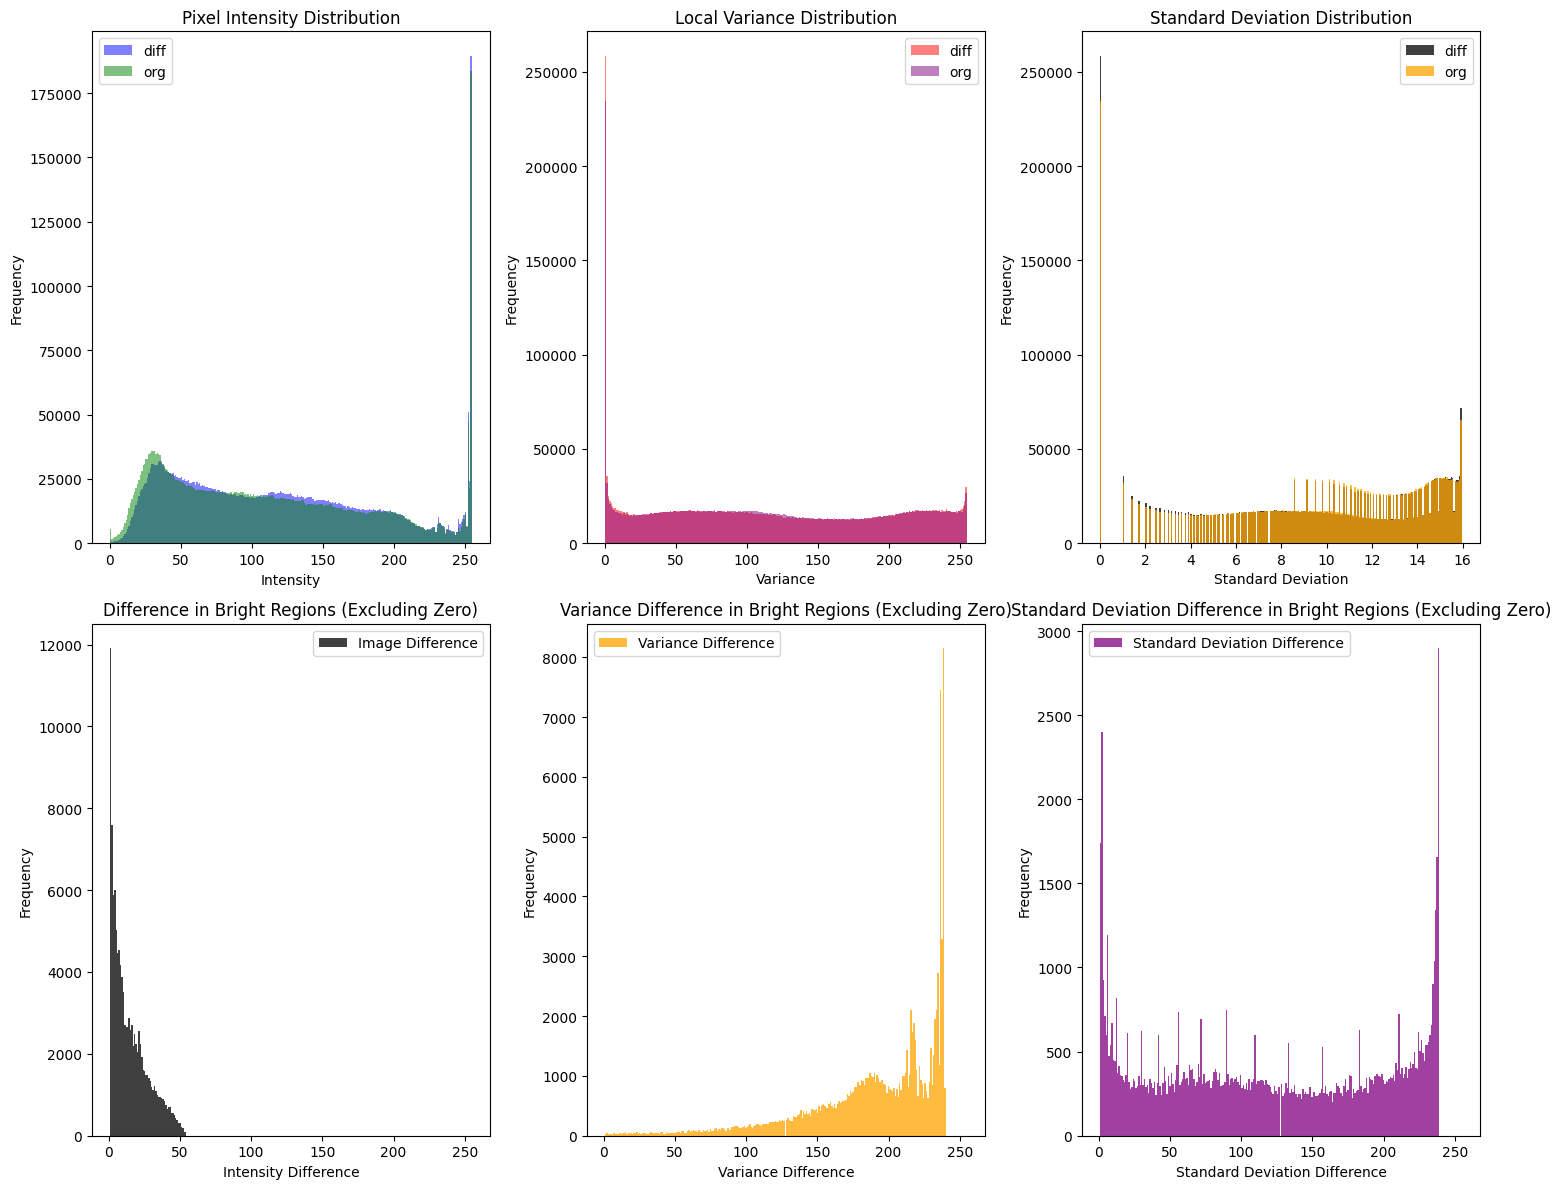

In [82]:
variance_diff = compute_local_variance(image_diff)
variance_org = compute_local_variance(image_org)
std_diff = compute_local_standard_deviation(image_diff)
std_org = compute_local_standard_deviation(image_org)

diff_image, diff_variance, diff_std = extract_bright_differences(image_diff, variance_diff, std_diff, image_org, variance_org, std_org)
plot_statistics(image_diff, variance_diff, std_diff, image_org, variance_org, std_org, diff_image, diff_variance, diff_std)

***NOTE:***
* **Bright regions** simply refer to the areas with high pixel values.
* **Variance in bright regions** looks at how those pixel values spread out or fluctuate in a specific bright region. For instance, a bright area with some variation in pixel values would have a higher variance, whereas a bright, uniform area (like a plain white surface) would have a low variance.
* We should exclude difference with value 0, because its the most numerous group here - order of magnitude 10^6, but it gives us no useful information.
* **Standard deviation** may be also useful to look at as it gives us more uniform output, however it doesnt seem to be more useful than variance difference

## 03. Heatmap to visualize where the pixels actually differ

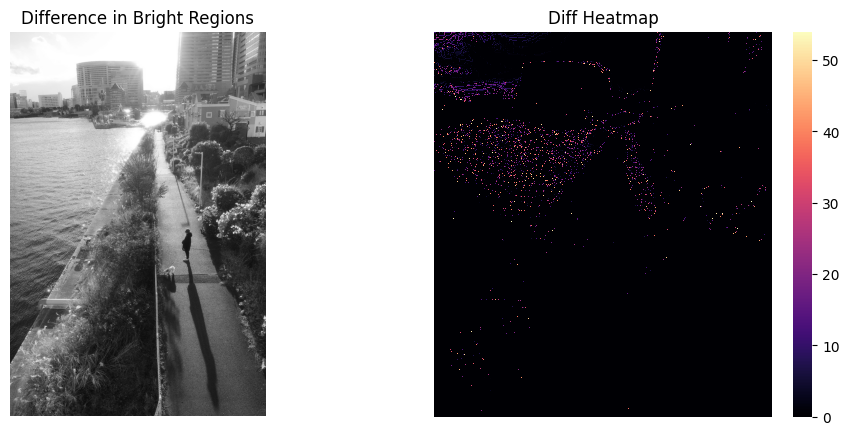

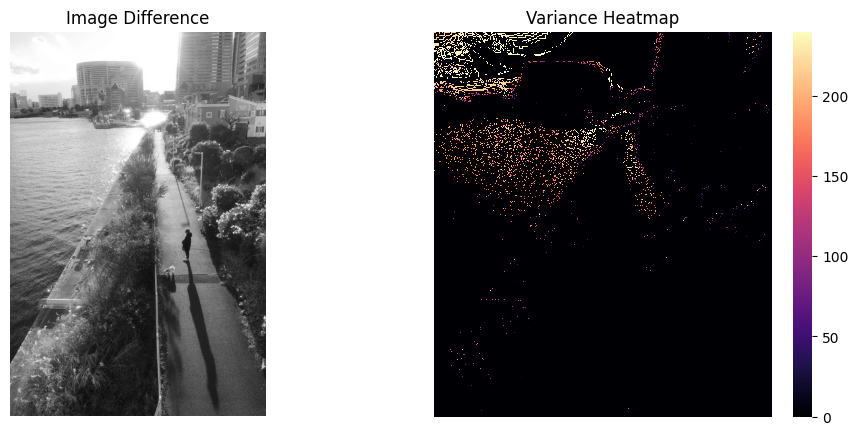

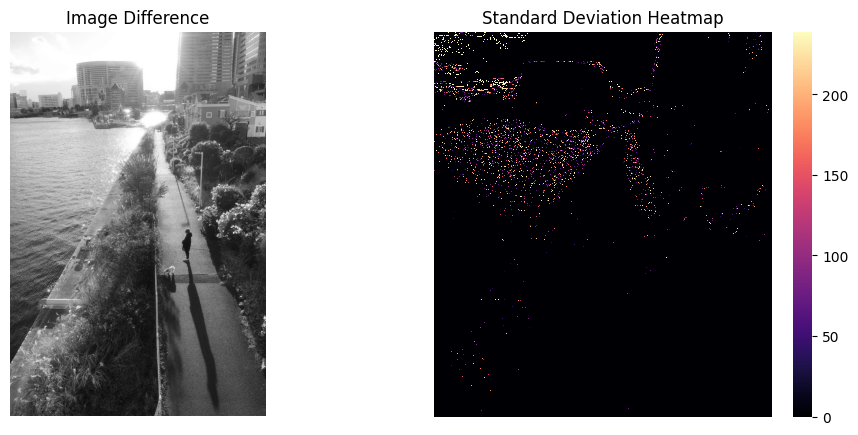

In [83]:
# Heatmaps for visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_diff, cmap='gray')
plt.title("Difference in Bright Regions")
plt.axis("off")

plt.subplot(1, 2, 2)
if diff_image.ndim == 3:  # If the image is mistakenly in RGB, convert to grayscale
    diff_image = cv2.cvtColor(diff_image, cv2.COLOR_BGR2GRAY)
sns.heatmap(diff_image, cmap='magma', cbar=True)
plt.title("Diff Heatmap")
plt.axis("off")

plt.show()

# Displaying image difference next to heatmap
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_diff, cmap='gray')
plt.title("Image Difference")
plt.axis("off")

plt.subplot(1, 2, 2)
if diff_variance.ndim == 3:  # If the image is mistakenly in RGB, convert to grayscale
    diff_variance = cv2.cvtColor(diff_variance, cv2.COLOR_BGR2GRAY)
sns.heatmap(diff_variance, cmap='magma', cbar=True)
plt.title("Variance Heatmap")
plt.axis("off")

plt.show()

# Displaying image difference next to heatmap
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_diff, cmap='gray')
plt.title("Image Difference")
plt.axis("off")

plt.subplot(1, 2, 2)
if diff_std.ndim == 3:  # If the image is mistakenly in RGB, convert to grayscale
    diff_std = cv2.cvtColor(diff_std, cv2.COLOR_BGR2GRAY)
sns.heatmap(diff_std, cmap='magma', cbar=True)
plt.title("Standard Deviation Heatmap")
plt.axis("off")

plt.show()


***NOTE:***

1. The images do not differ in regions that are fully overexposed—pixels cannot exceed the maximum value of 255, which results in *pure white* areas.
2. The diffusion filter causes light to diffuse around the brightest parts of the image. The affected area becomes more significant when the light source is strong. As a result, we may not be able to apply the filter locally, as the effect can influence nearly half of the image and weakens with distance from the light source.
3. **Variance** provides more detailed insight into the impact of diffusion on the image compared to a simple pixel value difference.
